# Figure 12: Impedance match


In [1]:
%run import-modules-grid

import holoviews as hv
from holoviews import opts
hv.extension('bokeh')


from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

!jupyter --version

import colormaps as local_cmaps

Platform:  Darwin Kernel Version 24.1.0: Thu Oct 10 21:00:32 PDT 2024; root:xnu-11215.41.3~2/RELEASE_ARM64_T6030
python version:  3.11.10
matplotlib version:  3.9.2
hvplot version:  0.11.0
numpy version:  2.1.2
pandas version:  2.2.3
pickle version:  4.0
yaml version:  6.0.2
pint version:  0.24.3
pyko version:  v0.8.3-dev-2024-05-12
print eos_table version:  v1.1.5b

Number of CPUs in the system: 12


Selected Jupyter core packages...


IPython          : 8.28.0


ipykernel        : 6.29.5
ipywidgets       : 8.1.5
jupyter_client   : 8.6.3
jupyter_core     : 5.7.2
jupyter_server   : 2.14.2


jupyterlab       : 4.2.5
nbclient         : 0.10.0


nbconvert        : 7.16.4
nbformat         : 5.10.4
notebook         : not installed
qtconsole        : not installed
traitlets        : 5.14.3


In [2]:
def pyko_to_normal_panda(pkodata):
    jmaxmat1=np.max(np.where(pkodata.mat.magnitude ==1)[0])
    pkodata.temp[jmaxmat1-5:jmaxmat1+1] = pkodata.temp[jmaxmat1-6]
    pkodata.temp[jmaxmat1+1:jmaxmat1+7] = pkodata.temp[jmaxmat1+7]
    pkodata.rho[jmaxmat1-5:jmaxmat1+1] = pkodata.rho[jmaxmat1-6]
    pkodata.rho[jmaxmat1+1:jmaxmat1+7] = pkodata.rho[jmaxmat1+7]
    df = pd.DataFrame({
            "j"    : pkodata.j.magnitude,
            "stepn" : pkodata.stepn.magnitude,
            "time" : pkodata.time.magnitude,
            "mat" : pkodata.mat.magnitude,
            "pos" : pkodata.pos.magnitude,
            "dr" : pkodata.dr.magnitude,
            "rho0" : pkodata.rho0.magnitude,
            "rho" : pkodata.rho.magnitude,
            "up" : pkodata.up.magnitude,
            "ie" : pkodata.ie.magnitude,
            "pres" : pkodata.pres.magnitude,
            "mass" : pkodata.mass.magnitude*4*np.pi, # convert to true total mass
            "temp" : pkodata.temp.magnitude,
            "cs" : pkodata.alocal.magnitude,
            "phase" : pkodata.phase.magnitude,
            "etot" : pkodata.etot.magnitude,
            "dtminj" : pkodata.dtminj.magnitude,
            })
    return df
def pyko_to_pos_panda(pkodata,jmaxmat1):
    posdata = (np.arange(15000)+1)*2*1.E3 #m
    df = pd.DataFrame({
            "time" : np.interp(posdata,pkodata.pos.magnitude,pkodata.time.magnitude)/3600,
            "mat" : np.interp(posdata,pkodata.pos.magnitude,pkodata.mat.magnitude),
            "rho" : np.log10(np.interp(posdata,np.concatenate((pkodata.pos.magnitude[2:jmaxmat1-2], pkodata.pos.magnitude[jmaxmat1+3::])),np.concatenate((pkodata.rho.magnitude[2:jmaxmat1-2], pkodata.rho.magnitude[jmaxmat1+3::])))/1.e3), # log10 g/cm3
            "pres" : np.log10(np.interp(posdata,np.concatenate((pkodata.pos.magnitude[2:jmaxmat1-2], pkodata.pos.magnitude[jmaxmat1+3::])),np.concatenate((pkodata.pres.magnitude[2:jmaxmat1-2], pkodata.pres.magnitude[jmaxmat1+3::])))/1.e5), # log10 bar
            "up" : np.interp(posdata,np.concatenate((pkodata.pos.magnitude[2:jmaxmat1-2], pkodata.pos.magnitude[jmaxmat1+3::])),np.concatenate((pkodata.up.magnitude[2:jmaxmat1-2], pkodata.up.magnitude[jmaxmat1+3::]))), # m/s
            "temp" : np.interp(posdata,np.concatenate((pkodata.pos.magnitude[2:jmaxmat1-2], pkodata.pos.magnitude[jmaxmat1+3::])),np.concatenate((pkodata.temp.magnitude[2:jmaxmat1-2], pkodata.temp.magnitude[jmaxmat1+3::]))),
            "pos" : posdata/1.e3 # km
            })
    return df
def pyko_to_pos_panda_clean(pkodata):
    posdata = (np.arange(25000)+1)*4*1.E3 #m
    df = pd.DataFrame({
            "time" : np.interp(posdata,pkodata.pos.magnitude,pkodata.time.magnitude)/3600,
            "mat" : np.interp(posdata,pkodata.pos.magnitude,pkodata.mat.magnitude),
            "rho" : np.log10(np.interp(posdata,pkodata.pos.magnitude,pkodata.rho.magnitude)*1.e-3), # log_10 of g/cm3
            "pres" : np.log10(np.interp(posdata,pkodata.pos.magnitude,pkodata.pres.magnitude)/1.e5), # log_10 of bar
            "up" : np.interp(posdata,pkodata.pos.magnitude,pkodata.up.magnitude), # m/s
            "temp" : np.interp(posdata,pkodata.pos.magnitude,pkodata.temp.magnitude), # K 
            "pos" : posdata/1.e3 # km
            })
    return df
def pyko_to_pos_panda_track(pkodata):
    npos = 1000
    maxrad = np.max(pkodata.pos.magnitude) # m
    posdata = (np.arange(npos)+1)/npos*maxrad  #m
    jmaxmat1=np.max(np.where(pkodata.mat.magnitude ==1)[0])
    pkodata.temp[jmaxmat1-5:jmaxmat1+1] = pkodata.temp[jmaxmat1-6]
    pkodata.temp[jmaxmat1+1:jmaxmat1+6] = pkodata.temp[jmaxmat1+6]
    pkodata.rho[jmaxmat1-5:jmaxmat1+1] = pkodata.rho[jmaxmat1-6]
    pkodata.rho[jmaxmat1+1:jmaxmat1+6] = pkodata.rho[jmaxmat1+6]
    df = pd.DataFrame({
            "time" : np.zeros(npos)+pkodata.time[0].magnitude/3600.,#np.interp(posdata,pkodata.pos.magnitude,pkodata.time.magnitude)/3600, # hr
            "mat" : np.round(np.interp(posdata,pkodata.pos.magnitude,pkodata.mat.magnitude)),
            "rho" : np.log10(np.interp(posdata,pkodata.pos.magnitude,pkodata.rho.magnitude)), # log_10 of kg/m3
            "pres" : np.log10(np.interp(posdata,pkodata.pos.magnitude,pkodata.pres.magnitude)), # log_10 of Pa
            "up" : np.interp(posdata,pkodata.pos.magnitude,pkodata.up.magnitude), # m/s
            "temp" : np.interp(posdata,pkodata.pos.magnitude,pkodata.temp.magnitude), # K 
            "pos" : posdata/1.e6# Mm
            })
    return df

In [3]:

###%%capture cap
rplumeinitarr = np.asarray([25.e3]) # m
rnebinitarr = np.asarray([100.e6]) #m
tsavearr = np.asarray([.000001]) #s
pinitarr = np.asarray([40.e9,20.e9,10.e9])
#tendarr = np.asarray([500,1000,1500])*1.e6
tendarr = np.asarray([500,1000,1500])*1.e6
velinitarr = np.asarray([0.]) # m/s

maxtime = 86400

all_label = []
all_tmax = []
all_pmax = []
all_cvol = []
all_rstall = []
all_plumeIM = []
all_nebIM = []

if 1:
#    fin='./vp-h2o-dig-tempgridlong-p1Pa-small2/vp-h2o-tempgridlong-dg100.yml'
#    fout='./vp-h2o-dig-tempgridlong-p1Pa-small2/vp-h2o-tempgridlong-dg100-'
    fin='./data/vp-h2o-exp-dg1.yml'
    #fout='./vp-h2o-expansion/vp-h2o-exp-dg1-'
    fout='./data/vp-h2o-exp2-dg1-'

    ftype='YAML'
    verbose=True
    userdtstart=0.
    usertstepscale=0.
    binoutput=True
    debug=False
    initarr=False
    #run = RunClass(fin=fin,fout=fout,ftype=ftype)    # initialize run parameters class
    #
    # read in the run template
    #readinput_yaml(run,verbose=0)
    #print(run.ieos[0].path)
    #hugarr = np.loadtxt(run.ieos[0].path+'NEW-SESAME-HUG-E.TXT',skiprows=3,delimiter=',')
    #print('Hugoniot file size = ',hugarr.shape)
    # vary starting parameters
    for ipp in range(len(pinitarr)):
#    for ipp in [0]:
        for irp in range(len(rplumeinitarr)):
            for ivel in range(len(velinitarr)):            
                fileid = 'P'+str(np.round(pinitarr[ipp]/1.e9))+'-R'+str(np.round(rplumeinitarr[irp]/1.e3))+'-V'+str(np.round(velinitarr[ivel]/1.e2)/10)
                #fileid='cth5-ring'
                outputfilename = fout+fileid+'.dat'
                label = 'dg1-'+fileid[0:-7]
                print("#outputfilename='"+outputfilename+"'")
                pykofileout = outputfilename
                pko = [] # this variable will hold a plain (no units) pandas datafram for plotting
                pkopos = []
                pkoposclean = []
                pkopostrack = []
                pkodata = OutputClass() # pandas + pint dataframe to read the pickled output data
                #
                # function to convert the stored pandas structure with pint units to a normal panda file
                # hvplot tools do not work with a panda+pint file
                # this also lets the user select a subset of variables to read into this notebook
                
                #
                # loop through all the pickle dumps to read in the simulation data
                # concat onto a pandas dataframe that stores the variables vs. time
                with open(pykofileout,"rb") as f:
                    pkodata = pickle.load(f) # keeps units
                    if 0:
                        # print units
                        print('pyKO output file units are the same as the input file units:')
                        print('   Time        ',pkodata.time.units)
                        print('   Position    ',pkodata.pos.units)
                        print('   Density     ',pkodata.rho.units)
                        print('   Part. vel.  ',pkodata.up.units)
                        print('   Int. energy ',pkodata.ie.units)
                        print('   Mass        ',pkodata.mass.units)
                        print('   Temperature ',pkodata.temp.units)
                        print('   Sound speed ',pkodata.alocal.units)
                        print('   Pressure    ',pkodata.pres.units)
                        print('   Stress      ',pkodata.sigmar.units)
                    #jmaxmat1=max(np.where(pkodata.mat.magnitude==1)[0])
                    pko = pyko_to_normal_panda(pkodata)
                    jmaxmat1=max(pko['j'][pko['time']==0][pko['mat']==1])
                    pkopos = pyko_to_pos_panda(pkodata,jmaxmat1)
                    pkoposclean = pyko_to_pos_panda_clean(pkodata)
                    pkopostrack = pyko_to_pos_panda_track(pkodata)
                    count=0
                    modval=1
                    while True:
                        try:
                            pkodata = pickle.load(f) # keeps units but only one snapshot at a time
                            if (count % modval)==0:
                                pko = pd.concat([pko,pyko_to_normal_panda(pkodata)],ignore_index=True) # strips units for plotting
                                #pkopos = pd.concat([pkopos,pyko_to_pos_panda(pkodata,jmaxmat1)],ignore_index=True) # strips units for plotting
                                #pkoposclean = pd.concat([pkoposclean,pyko_to_pos_panda_clean(pkodata)],ignore_index=True) # strips units for plotting
                                #pkopostrack = pd.concat([pkopostrack,pyko_to_pos_panda_track(pkodata)],ignore_index=True) # strips units for plotting
                            count=count+1
                            if max(pko['time']>maxtime):
                                break
                        except:
                            break
                timeall = np.unique(pko['time'])/3600.
    
                pko = pko.assign(material = pko.mat)
                imat1 = np.where((pko['mat'] == 1))[0]
                #pko['material'][imat1]=1
                imat2 = np.where((pko['mat'] == 2))[0]
                #pko['material'][imat2]=2
                jmaxmat1=max(pko['j'][pko['time']==0][pko['mat']==1])
                
                # convert to same units as fKO for plot comparisons
                # from binary in mks
                #pko['ie']     *= 1.E-11*pko['rho0']    # J/kg * kg/m3 -> 100 GJ/m3 = eu/cm3
                #pko.rename(columns={"ie": "iev0"},inplace=True)
                pko['etot']   *= 1.E-8    # J/kg 10e7 erg/1000 g -> erg/g *1.e-12 -> eu/g
                #print('iev0 and etot converted to eu/g')
                pko['time']   /= 3600    # s-> hr
                pko['dtminj'] *= 1.0E6    # s->microseconds
                pko['pos']    *= 1.0E-6    # m->Mm
                #pko['pres']   *= 1.E-5    # Pa -> bar
                pko['rho']    *= 1.E-3    # kg/m3 -> g/cm3
                pko['rho0']   *= 1.E-3    # kg/m3 -> g/cm3
    
                timeall = np.unique(pko['time'])
                

                jmaxmat1=max(pko['j'][pko['mat']==1])
                plupko = pko[['pres', 'up','rho','temp','j','time','pos']][pko['j']==jmaxmat1].copy()
                nebpko = pko[['pres', 'up','rho','temp','j','time','pos']][pko['j']==jmaxmat1+2].copy()
                #plupko.to_csv(outputfilename[0:-4]+'-IM.csv')

                all_plumeIM.append(plupko)
                all_nebIM.append(nebpko)
                
##                %run plot-save-three.ipynb
##                %run plot-save.ipynb
##                stop

#outputfilename='./data/vp-h2o-exp2-dg1-P40.0-R25.0-V0.0.dat'


#outputfilename='./data/vp-h2o-exp2-dg1-P20.0-R25.0-V0.0.dat'
#outputfilename='./data/vp-h2o-exp2-dg1-P10.0-R25.0-V0.0.dat'


In [4]:
rhogas = 2.e-7 # kg/m3
rhodust = 3000 # kg/m3
vol = 1 # m3
mgas = rhogas*vol # kg
dtog = np.asarray([.01,0.1,1,10,100,1000,10000,100000]) # = mdust/mgas
#dtog = np.asarray([10]) # = mdust/mgas
#dtog = np.asarray([10000]) # = mdust/mgas
#dtog = np.asarray([1]) # = mdust/mgas
mdust = mgas*dtog # kg
m = mgas + mdust
rho = m/vol
k = mdust/m # = mdust/mtot
vdust = mdust/rhodust
# v = vgas + vdust
G = rhodust/rhogas
# vanishing dust volume G -> infinity
Z = vdust/vol 
Z2 = k / ( (1-k)*G+k )

T=200 # K
Rgas=8.314 # J/mol/K
#moltokg = .002 # pure H2 gas kg/mol
fh=12 # lodders elemental abundances for proto sun
fhe=10.984
mugas = (fh*1+fhe*4)/(fh+fhe)
print(mugas)
moltokg = .002433 # H2+He gas kg/mol


P = (1-k)/(1-Z) * Rgas/moltokg*rho*T # a partial pressure
Pidg = Rgas/moltokg*rhogas*T

delta = k/(1-k)
beta = 1000/(5/2*Rgas/moltokg)
g = 1.4
gamma = (g+delta*beta)/(1+delta*beta)
cs = np.sqrt( gamma*(1-k)/(1-Z)/(1-Z) * Rgas/moltokg * T)
ie = (1-Z)/(gamma-1)*(P/rho)
cvgas = 5/2*Rgas/moltokg
cpgas = 1.4*cvgas
cpdust = 1000 # e.g. olivine at a few 100 K http://english.gyig.cas.cn/pu/papers_CJG/201803/P020180316540125048801.pdf
cpmix = k*cpdust+(1-k)*cpgas
cvmix = cpmix/gamma



nr=len(rho)
npres=1000
hugallp = np.zeros((nr,npres))
hugallr = np.zeros((nr,npres))
hugallt = np.zeros((nr,npres))
hugallup = np.zeros((nr,npres))
hugallus = np.zeros((nr,npres))

#for ir in range(5,len(rho)):
for ir in range(0,7):
    rarr = np.power(10,np.arange(0,5,.01))*rho[ir]
    parr = np.power(10,np.arange(0,10,.01))*P[ir]
    print(len(parr))
#    print(rarr)
#    print(parr)
    e0 = (1-Z[ir])/(gamma[ir]-1)*(P[ir]/rho[ir])
    rhug = np.zeros(0)
    print(rho[ir],P[ir],e0)
    for ip in range(len(parr)):
        earr = (1-Z[ir])/(gamma[ir]-1)*(parr[ip]/rarr)
        huge = (earr-e0)-0.5*parr[ip]*(1/rho[ir]-1/rarr)
        rint = np.interp(0,np.flip(huge),np.flip(rarr))
        eint = np.interp(rint,rarr,earr)
        hugallp[ir,ip]=parr[ip]
        hugallr[ir,ip]=rint
        hugallt[ir,ip]=eint/cvmix[ir]
        hugallup[ir,ip] = np.sqrt((hugallp[ir,ip]-P[ir])*(1/rho[ir]-1/hugallr[ir,ip]))
        hugallus[ir,ip] = (1/rho[ir])*np.sqrt((hugallp[ir,ip]-P[ir])/(1/rho[ir]-1/hugallr[ir,ip]))
        #print(huge,rarr,rint)
        #stop






2.43369300382875
1000
2.0199999999999998e-07 0.13668721742713594 1693653.6810277828
1000
2.1999999999999998e-07 0.13668721742795606 1571445.6525800554
1000
4e-07 0.13668721743615728 954295.1089190303
1000
2.2e-06 0.13668721751816984 337144.56525800575
1000
2.02e-05 0.13668721833829459 214936.53681027793
1000
0.0002002 0.13668722653953713 201507.08313469487
1000
0.0020002 0.13668730855193992 200150.843937326


/var/folders/4z/xws_ywgj78sc494vpwymn9bw0000gn/T/ipykernel_10263/2096756836.py:74: RuntimeWarning: invalid value encountered in scalar divide
  hugallus[ir,ip] = (1/rho[ir])*np.sqrt((hugallp[ir,ip]-P[ir])/(1/rho[ir]-1/hugallr[ir,ip]))


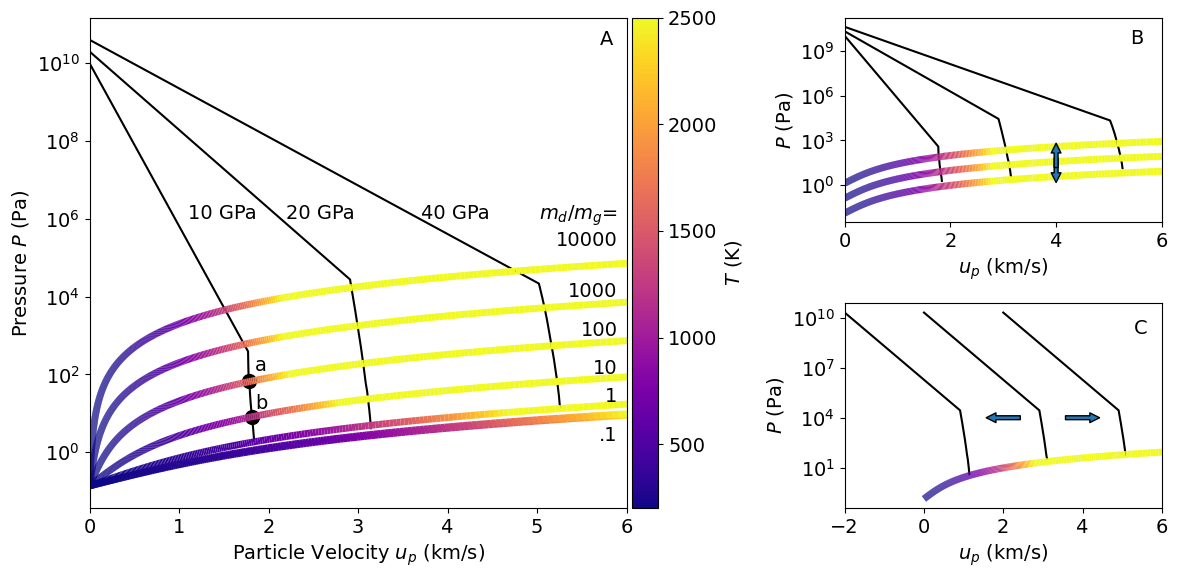

In [5]:
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams.update({'font.size': 14})

fig=plt.figure()
ax1 = plt.subplot2grid(shape=(2, 5), loc=(0, 0), colspan=3, rowspan=2)
ax2 = plt.subplot2grid(shape=(2, 5), loc=(0, 3),colspan=2)
ax3 = plt.subplot2grid(shape=(2, 5), loc=(1, 3),colspan=2)


tmax=2500
tmin=200

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(tmin,tmax)

for ii in range(len(all_plumeIM)):
    plupko = all_plumeIM[ii]
    ax1.plot(plupko['up']/1.e3,plupko['pres'],'k-')
    ax2.plot(plupko['up']/1.e3,plupko['pres'],'k-')

if 1:
    ii=1
    plupko = all_plumeIM[ii]
    nn=len(plupko['pres'])
    ax3.plot(plupko['up'][0:nn-5]/1.e3,plupko['pres'][0:nn-5],'k-')
    ax3.plot(plupko['up']/1.e3-2.000,plupko['pres'],'k-')
    ax3.plot(plupko['up'][0:nn-6]/1.e3+2.000,plupko['pres'][0:nn-6],'k-')

ax1.text(1.100,1.e6,'10 GPa')
ax1.text(2.200,1.e6,'20 GPa')
ax1.text(3.700,1.e6,'40 GPa')

sss = 14
xxx = 5.900
ax1.text(xxx,2.e5,'$m_d/m_g$=\n10000',fontsize=sss,ha='right')
ax1.text(xxx,1.e4,'1000',fontsize=sss,ha='right')
ax1.text(xxx,1000,'100',fontsize=sss,ha='right')
ax1.text(xxx,100,'10',fontsize=sss,ha='right')
ax1.text(xxx,20,'1',fontsize=sss,ha='right')
ax1.text(xxx,2,'.1',fontsize=sss,ha='right')

for ir in range(7):
    if 1:
        x = hugallup[ir,:]/1.e3
        y = hugallp[ir,:]
        dydx = hugallt[ir,:]
        
        # Create a set of line segments so that we can color them individually
        # This creates the points as a N x 1 x 2 array so that we can stack points
        # together easily to get the segments. The segments array for line collection
        # needs to be (numlines) x (points per line) x 2 (for x and y)
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        # Create a continuous norm to map from data points to colors
        norm = plt.Normalize(tmin, tmax)
        lc = LineCollection(segments, cmap=local_cmaps.plasma, norm=norm)
        # Set the values used for colormapping
        lc.set_array(dydx)
        lc.set_linewidth(5)
        line=ax1.add_collection(lc)
        #.plot(hugallup[ir,:],hugallp[ir,:],'+')

ax1.text(5.700,3.e10,'A')
ax2.text(5.400,.3e10,'B')
ax3.text(5.300,.1e10,'C')

# plot varying initial pressure in B
if 1:
    ir=3
    x = hugallup[ir,:]/1.e3
    y = hugallp[ir,:]
    dydx = hugallt[ir,:]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(tmin, tmax)
    lc = LineCollection(segments, cmap=local_cmaps.plasma, norm=norm)
    # Set the values used for colormapping
    lc.set_array(dydx)
    lc.set_linewidth(5)
    line=ax2.add_collection(lc)

    x = hugallup[ir,:]/1.e3
    y = hugallp[ir,:]*10
    dydx = hugallt[ir,:]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(tmin, tmax)
    lc = LineCollection(segments, cmap=local_cmaps.plasma, norm=norm)
    # Set the values used for colormapping
    lc.set_array(dydx)
    lc.set_linewidth(5)
    line=ax2.add_collection(lc)

    x = hugallup[ir,:]/1.e3
    y = hugallp[ir,:]*.1
    dydx = hugallt[ir,:]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(tmin, tmax)
    lc = LineCollection(segments, cmap=local_cmaps.plasma, norm=norm)
    # Set the values used for colormapping
    lc.set_array(dydx)
    lc.set_linewidth(5)
    line=ax2.add_collection(lc)

# plot varying initial up in C
if 1:
    ir=3
    x = hugallup[ir,:]/1.e3
    y = hugallp[ir,:]
    dydx = hugallt[ir,:]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(tmin, tmax)
    lc = LineCollection(segments, cmap=local_cmaps.plasma, norm=norm)
    # Set the values used for colormapping
    lc.set_array(dydx)
    lc.set_linewidth(5)
    line=ax3.add_collection(lc)

# arrows
import matplotlib.patches as mpatches


x_tail = 4.000
y_tail = 100
x_head = 4.000
y_head = 1
dx = x_head - x_tail
dy = y_head - y_tail
arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                 mutation_scale=14)
ax2.add_patch(arrow)
arrow.set_zorder(5)

x_tail = 4.000
y_tail = 10
x_head = 4.000
y_head = 1000
dx = x_head - x_tail
dy = y_head - y_tail
arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                 mutation_scale=14)
ax2.add_patch(arrow)
arrow.set_zorder(7)


x_tail = 2.500
y_tail = 1.e4
x_head = 1.500
y_head = 1.e4
dx = x_head - x_tail
dy = y_head - y_tail
arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                 mutation_scale=14)
ax3.add_patch(arrow)

x_tail = 3.500
y_tail = 1.e4
x_head = 4.500
y_head = 1.e4
dx = x_head - x_tail
dy = y_head - y_tail
arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                 mutation_scale=14)
ax3.add_patch(arrow)
#ax3.arrow(2500,1.e4,-1000,-1000,head_width=1)

ax1.scatter(1.780,70,c='k',s=100)
ax1.scatter(1.820,8,c='k',s=100)
ax1.text(1.850,120,'a')
ax1.text(1.850,13,'b')


ax1.set_xlim(0,6.000)
ax1.set_yscale('log')
ax2.set_xlim(0,6.000)
ax2.set_yscale('log')
ax3.set_xlim(-2.000,6.000)
ax3.set_yscale('log')
#ax1.set_colorbar(line,label='Temperature (K)')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(line, cax=cax, orientation='vertical',label='$T$ (K)')

ax1.set_xlabel('Particle Velocity $u_p$ (km/s)')
ax1.set_ylabel('Pressure $P$ (Pa)')
ax2.set_xlabel('$u_p$ (km/s)')
ax2.set_ylabel('$P$ (Pa)')
ax3.set_xlabel('$u_p$ (km/s)')
ax3.set_ylabel('$P$ (Pa)')
plt.tight_layout()
plt.savefig('plots/Fig12-release-dig-plasma-panels-kms.pdf')
